In [1]:
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())

os.environ['PM4PY_SHOW_EVENT_LOG_DEPRECATION'] = 'false'

/home/vco/Teaching/2024_HealthcareInformatics/src


In [2]:
import pandas as pd
import pm4py
import matplotlib.pyplot as plt

from pm4py.algo.discovery.dcr_discover import algorithm as discover_alg

from pm4py.objects.dcr.importer import importer as dcr_importer
from pm4py.objects.dcr.exporter import exporter as dcr_exporter

from pm4py.algo.conformance.dcr import algorithm as conformance_dcr
from pm4py.algo.conformance.alignments.dcr import algorithm as alignments_dcr
from pm4py.objects.dcr.obj import DcrGraph
from pm4py.objects.dcr.semantics import DcrSemantics

from pm4py.vis import view_events_distribution_graph,view_case_duration_graph

Note: The pm4py library we use in the notebook is an extension with DCR from the original pm4py library. You will find more information on using pm4py here

https://pm4py.fit.fraunhofer.de/documentation.

# Event log data analysis
Note: sepsis_df is a pandas dataframe. Feel free to use your knowledge of data frames and data analysis as you see fit. Exploratory Data Analysis (EDA) as you know it from Data Science should work as expected.

In [3]:
event_log_file = 'data/Sepsis Cases - Event Log.xes'
sepsis_df = pm4py.read_xes(event_log_file, infer_datetime_format=True) #loading the log
sepsis_df # note there are many NaN values, this is expected. When you have a not NaN value look at the concept:name to understand the link between the data attribute and the event.

,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,True,A,True,True,True,True,True,True,True,ER Registration,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15209,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,66.0,NaN
15210,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Release A,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,NaN,NaN
15211,False,L,False,False,False,False,False,False,False,ER Registration,...,False,complete,NaN,False,False,False,LNA,NaN,NaN,NaN
15212,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,LNA,NaN,NaN,NaN


In [4]:
returning = sepsis_df[sepsis_df['concept:name']=='Return ER']['case:concept:name'].unique().tolist()

In [5]:
sepsis_df.describe() # this will only describe numerical columns

,Age,Leucocytes,CRP,LacticAcid
count,1050.000000,3361.00000,3123.000000,1454.000000
mean,70.080952,12.94936,113.745757,1.949106
std,17.356744,14.99533,86.775355,1.478633
min,20.000000,0.20000,5.000000,0.200000
25%,60.000000,7.70000,43.000000,1.100000
50%,75.000000,11.00000,95.000000,1.600000
75%,85.000000,15.00000,162.000000,2.300000
max,90.000000,381.30000,573.000000,14.900000


In [6]:
sepsis_df.columns #list of all columns

Index(['InfectionSuspected', 'org:group', 'DiagnosticBlood', 'DisfuncOrg',
       'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 'Infusion',
       'DiagnosticArtAstrup', 'concept:name', 'Age', 'DiagnosticIC',
       'DiagnosticSputum', 'DiagnosticLiquor', 'DiagnosticOther',
       'SIRSCriteria2OrMore', 'DiagnosticXthorax', 'SIRSCritTemperature',
       'time:timestamp', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos',
       'Oligurie', 'DiagnosticLacticAcid', 'lifecycle:transition', 'Diagnose',
       'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG',
       'case:concept:name', 'Leucocytes', 'CRP', 'LacticAcid'],
      dtype='object')

In [7]:
#TODO add your code for question 1.1
sepsis_df['case:concept:name'].nunique()

1050

In [8]:
sepsis_returning_df = pm4py.read_xes('data/sepsis_returning.xes')
sepsis_returning_df['case:concept:name'].nunique()

294

Example: number of cases with hypotension.

In [9]:
sepsis_df[sepsis_df['Hypotensie']==True]['case:concept:name'].nunique()

54

In [10]:
#TODO add your code for 1.2
sepsis_df[sepsis_df['InfectionSuspected']==True]['case:concept:name'].nunique()

848

Example: Mean (average) patient age. Note that age is related to "ER Registration" and patients with a higher than average age.

In [11]:
sepsis_df[sepsis_df['concept:name']=='ER Registration']['Age'].describe()

count    995.000000
mean      70.190955
std       17.384679
min       20.000000
25%       60.000000
50%       75.000000
75%       85.000000
max       90.000000
Name: Age, dtype: float64

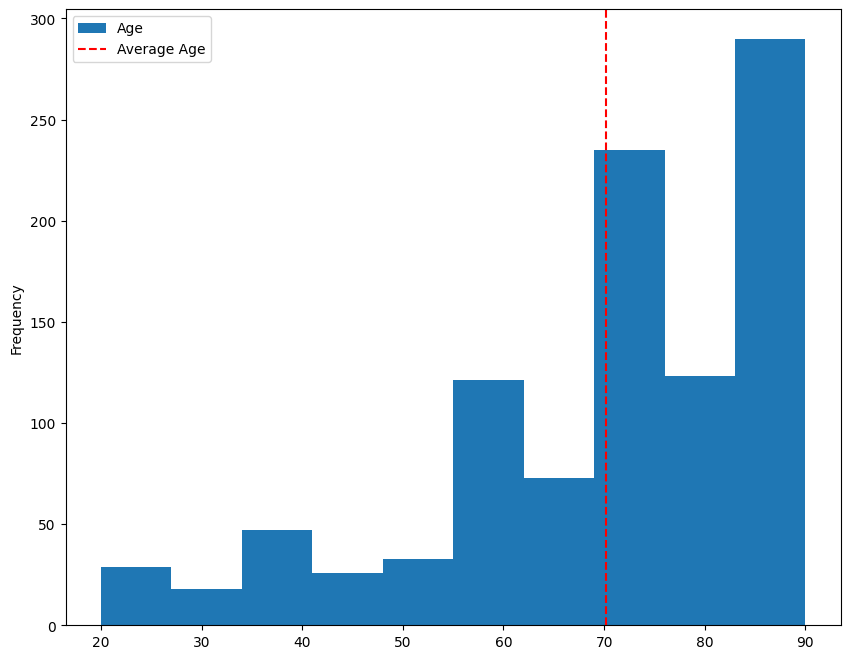

In [12]:
mean_age = sepsis_df[sepsis_df['concept:name']=='ER Registration']['Age'].mean()
ax = sepsis_df[sepsis_df['concept:name']=='ER Registration'].plot.hist(column=['Age'],figsize=(10, 8))
ax.axvline(x=mean_age,color='r',linestyle='--',label='Average Age')
ax.legend()

In [13]:
# Number of cases with a higher than average age according to the log
sepsis_df[(sepsis_df['Age']>mean_age) & (sepsis_df['concept:name']=='ER Registration')]['case:concept:name'].nunique()

543

In [14]:
sepsis_df[sepsis_df['concept:name']=='CRP']['CRP'].describe()

count    3123.000000
mean      113.745757
std        86.775355
min         5.000000
25%        43.000000
50%        95.000000
75%       162.000000
max       573.000000
Name: CRP, dtype: float64

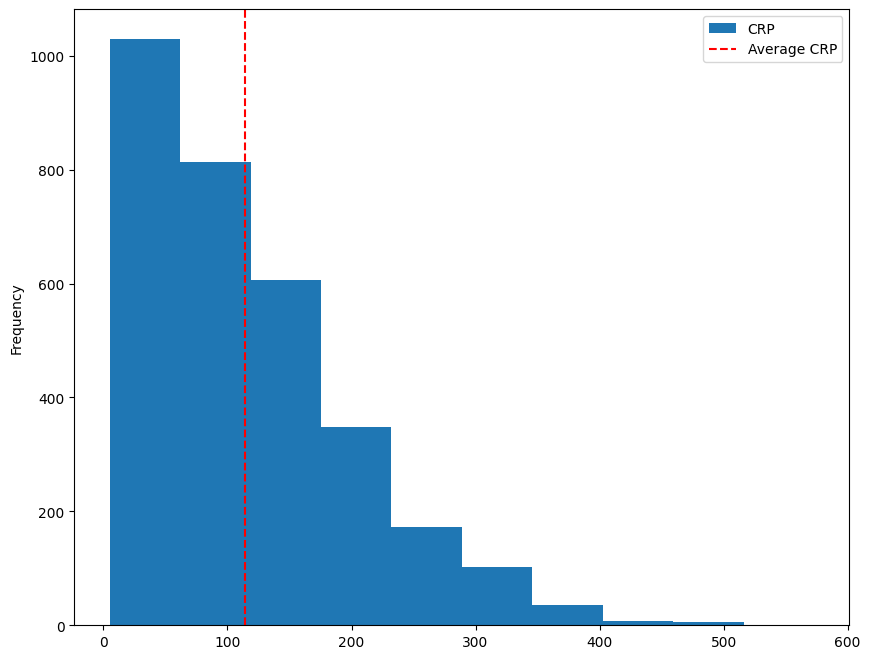

In [15]:
mean_crp = sepsis_df[sepsis_df['concept:name']=='CRP']['CRP'].mean()
ax = sepsis_df[sepsis_df['concept:name']=='CRP'].plot.hist(column=['CRP'],figsize=(10, 8))
ax.axvline(x=mean_crp,color='r',linestyle='--',label='Average CRP')
ax.legend()

In [16]:
# Number of cases with a higher than average age according to the log
sepsis_df[(sepsis_df['CRP']>mean_crp) & (sepsis_df['concept:name']=='CRP')]['case:concept:name'].nunique()

544

In [17]:
sepsis_df[sepsis_df['concept:name']=='Leucocytes']['Leucocytes'].describe()

count    3361.00000
mean       12.94936
std        14.99533
min         0.20000
25%         7.70000
50%        11.00000
75%        15.00000
max       381.30000
Name: Leucocytes, dtype: float64

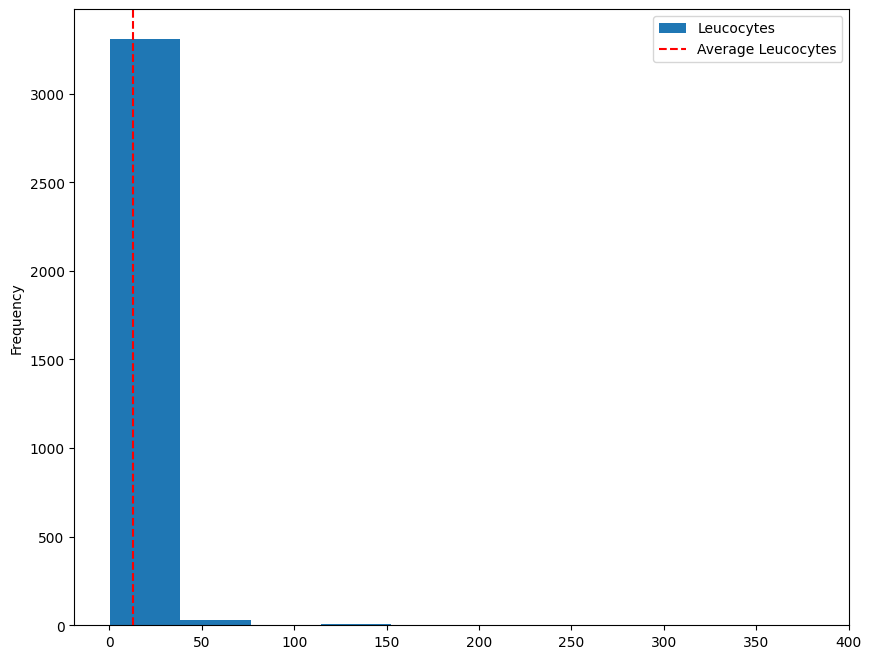

In [18]:
mean_l = sepsis_df[sepsis_df['concept:name']=='Leucocytes']['Leucocytes'].mean()
ax = sepsis_df[sepsis_df['concept:name']=='Leucocytes'].plot.hist(column=['Leucocytes'],figsize=(10, 8))
ax.axvline(x=mean_l,color='r',linestyle='--',label='Average Leucocytes')
ax.legend()

In [19]:
# Number of cases with a higher than average age according to the log
sepsis_df[(sepsis_df['Leucocytes']>mean_l) & (sepsis_df['concept:name']=='Leucocytes')]['case:concept:name'].nunique()

533

In [20]:
sepsis_df[sepsis_df['concept:name']=='LacticAcid']['LacticAcid'].describe()

count    1454.000000
mean        1.949106
std         1.478633
min         0.200000
25%         1.100000
50%         1.600000
75%         2.300000
max        14.900000
Name: LacticAcid, dtype: float64

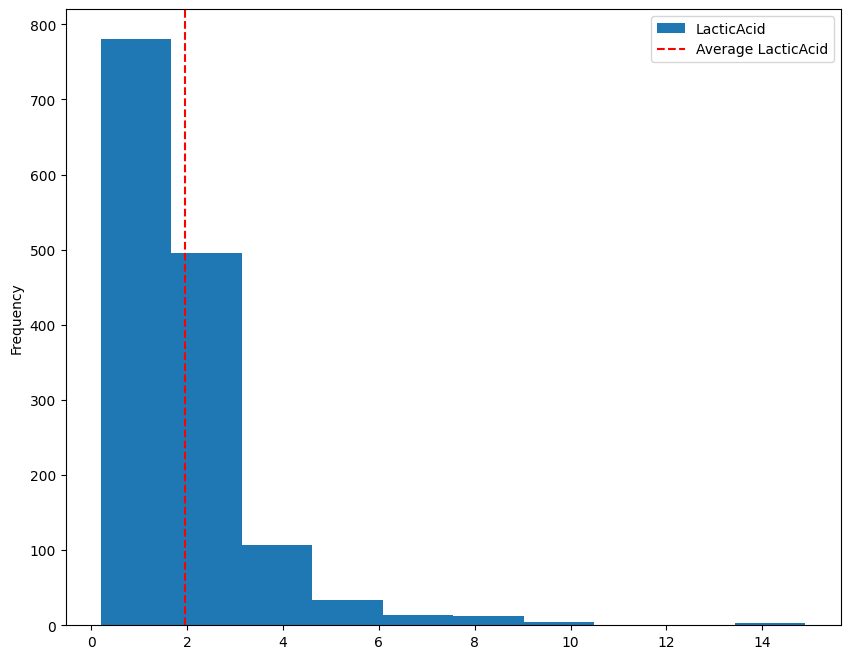

In [21]:
mean_la = sepsis_df[sepsis_df['concept:name']=='LacticAcid']['LacticAcid'].mean()
ax = sepsis_df[sepsis_df['concept:name']=='LacticAcid'].plot.hist(column=['LacticAcid'],figsize=(10, 8))
ax.axvline(x=mean_la,color='r',linestyle='--',label='Average LacticAcid')
ax.legend()

In [22]:
# Number of cases with a higher than average age according to the log
sepsis_df[(sepsis_df['LacticAcid']>mean_la) & (sepsis_df['concept:name']=='LacticAcid')]['case:concept:name'].nunique()

345

# More descriptive statistics

## Activity Ocurrences

In [23]:
sepsis_df["concept:name"].value_counts()

concept:name
Leucocytes          3383
CRP                 3262
LacticAcid          1466
Admission NC        1182
ER Triage           1053
ER Registration     1050
ER Sepsis Triage    1049
IV Antibiotics       823
IV Liquid            753
Release A            671
Return ER            294
Admission IC         117
Release B             56
Release C             25
Release D             24
Release E              6
Name: count, dtype: int64

# Activities in Cases

In [24]:
sepsis_df.groupby(["case:concept:name", "concept:name"]).first().reset_index()["concept:name"].value_counts()

concept:name
ER Registration     1050
ER Triage           1050
ER Sepsis Triage    1049
Leucocytes          1012
CRP                 1007
LacticAcid           860
IV Antibiotics       823
Admission NC         800
IV Liquid            753
Release A            671
Return ER            294
Admission IC         110
Release B             56
Release C             25
Release D             24
Release E              6
Name: count, dtype: int64

# Start Activities

In [25]:
sepsis_df.groupby("case:concept:name").first()["concept:name"].value_counts()

concept:name
ER Registration     995
Leucocytes           18
IV Liquid            14
CRP                  10
ER Sepsis Triage      7
ER Triage             6
Name: count, dtype: int64

# End Activites

In [26]:
sepsis_df.groupby("case:concept:name").last()["concept:name"].value_counts()

concept:name
Release A           393
Return ER           291
IV Antibiotics       87
Release B            55
ER Sepsis Triage     49
Leucocytes           44
CRP                  41
LacticAcid           24
Release C            19
Admission NC         14
Release D            14
IV Liquid            12
Release E             5
ER Triage             2
Name: count, dtype: int64

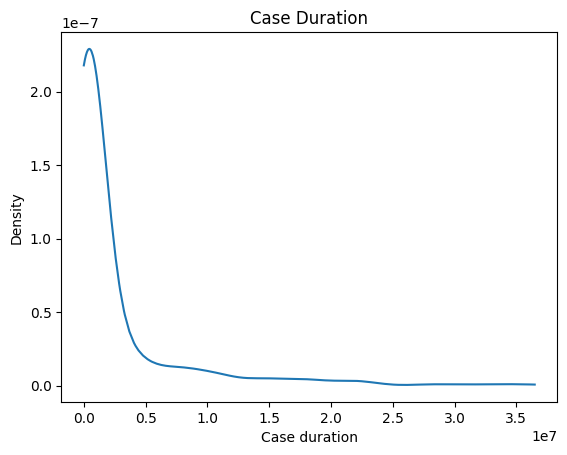

In [27]:
view_case_duration_graph(sepsis_df,kwargs={'pylot_plot_kwargs':{'linestyle':'-'}})

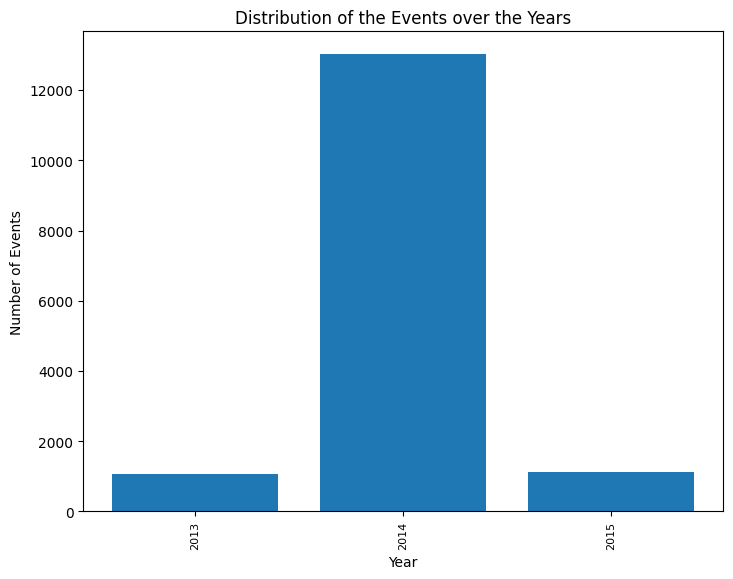

In [28]:
view_events_distribution_graph(sepsis_df,distr_type='years')

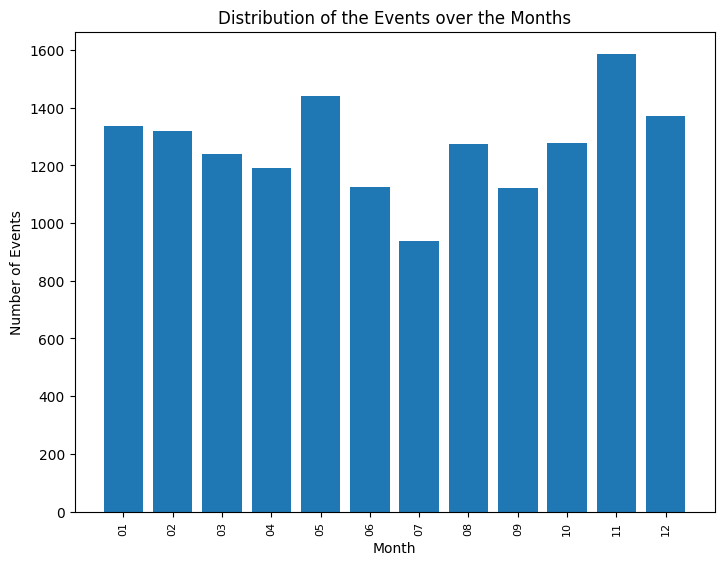

In [29]:
view_events_distribution_graph(sepsis_df,distr_type='months')

# Part 2.1 Process discovery
Note: The model mined with this version of DisCoveR is more complex than the one from the dcrgraphs.net portal. It finds more relations.

Note 2: 'conditionsFor' represents the inverse reading of a condition arrow (this was done for efficient checking of the enabledness definition). 
    For example, you should read that 'Release D' is a conditionFor 'Return ER' ('Release D'-->*'Return ER'), but in the python object you will see it as 'conditionsFor': 'Return ER' {'Release D',...

Note 3: The other relations 'includesTo' (-->+), 'excludesTo' (-->%), 'responseTo' (*-->) are represented in the python object in the same direction as the arrows indicate. 
    For example, 'excludesTo': { ... 'Return ER': {'Return ER', 'Release B' ... encodes the visual self exclusion on 'Return ER' and that 'Return ER' excludes 'Release B' ('Return ER' -->% 'Release B') 

In [30]:
dcr_sepsis_from_portal = dcr_importer.apply('models/dcr_from_portal.xml')
print('Inspect the mined DCR Graph from the portal')
print(f'[Found relations] {dcr_sepsis_from_portal.get_constraints()}')
print(f'[conditionsFor] {dcr_sepsis_from_portal.conditions}')
print(f'[excludesTo] {dcr_sepsis_from_portal.excludes}')
# when you discover (mine) a DCR Graph the marking you get will have all events included, none executed and none pending
print(f'[marking executed] {dcr_sepsis_from_portal.marking.executed}')
print(f'[marking included] {dcr_sepsis_from_portal.marking.included}')
print(f'[marking pending] {dcr_sepsis_from_portal.marking.pending}')

Inspect the mined DCR Graph from the portal
[Found relations] 35
[conditionsFor] {'Admission NC': {'ER Registration', 'ER Triage'}, 'Release A': {'ER Registration', 'ER Triage'}, 'Admission IC': {'ER Registration', 'ER Triage'}, 'Release B': {'ER Registration', 'ER Triage', 'CRP', 'Leucocytes', 'ER Sepsis Triage'}, 'Release C': {'Leucocytes', 'CRP', 'ER Sepsis Triage', 'Admission NC'}, 'Release D': {'Leucocytes', 'CRP', 'ER Sepsis Triage', 'Admission NC'}, 'Release E': {'Leucocytes', 'CRP', 'ER Sepsis Triage', 'Admission NC'}, 'IV Antibiotics': {'ER Sepsis Triage'}, 'Return ER': {'Admission NC'}}
[excludesTo] {'ER Registration': {'ER Registration'}, 'ER Sepsis Triage': {'ER Sepsis Triage'}, 'IV Liquid': {'IV Liquid'}, 'IV Antibiotics': {'IV Antibiotics'}, 'Release A': {'Release A'}, 'Return ER': {'Return ER'}, 'Release B': {'Release B'}, 'Release C': {'Release C'}, 'Release D': {'Release D'}, 'Release E': {'Release E'}}
[marking executed] set()
[marking included] {'Release C', 'ER Regi

In [31]:
dcr_sepsis, log_abstraction = discover_alg.apply(sepsis_df) # this discovers a model for the whole log
print('Inspect the mined DCR Graph from pm4py')
print(f'[Found relations] {dcr_sepsis.get_constraints()}')
print(f'[conditionsFor] {dcr_sepsis.conditions}')
print(f'[excludesTo] {dcr_sepsis.excludes}')
# when you discover (mine) a DCR Graph the marking you get will have all events included, none executed and none pending
print(f'[marking executed] {dcr_sepsis.marking.executed}')
print(f'[marking included] {dcr_sepsis.marking.included}')
print(f'[marking pending] {dcr_sepsis.marking.pending}')

Inspect the mined DCR Graph from pm4py
[Found relations] 91
[conditionsFor] {'Return ER': {'Release C', 'Release D', 'Release E', 'Admission IC', 'Release A'}, 'Release C': {'Leucocytes', 'CRP', 'ER Sepsis Triage', 'Admission NC'}, 'Release D': {'Leucocytes', 'CRP', 'ER Sepsis Triage', 'Admission NC'}, 'Release E': {'Leucocytes', 'CRP', 'ER Sepsis Triage', 'Admission NC'}, 'Release B': {'CRP', 'ER Registration', 'ER Triage', 'Leucocytes', 'ER Sepsis Triage'}, 'Admission NC': {'ER Registration', 'ER Triage'}, 'Admission IC': {'ER Registration', 'ER Triage'}, 'Release A': {'ER Registration', 'ER Triage'}, 'IV Antibiotics': {'ER Sepsis Triage'}, 'ER Registration': set(), 'ER Triage': set(), 'IV Liquid': set(), 'LacticAcid': set(), 'Leucocytes': set(), 'ER Sepsis Triage': set(), 'CRP': set()}
[excludesTo] {'Release C': {'Release C', 'ER Triage', 'Release D', 'Admission NC', 'LacticAcid', 'Leucocytes', 'Release B', 'Release E', 'CRP', 'Admission IC', 'Release A'}, 'ER Registration': {'ER Re

Example: play with the execution semantics in the notebook

In [32]:
def execute_and_check(event_to_execute,dcr_graph, dcr_semantics):
    enabled_events = dcr_semantics.enabled(dcr_graph)
    print(f'[Before executing {event_to_execute}] Enabled events: {enabled_events}') # check enabled events
    if event_to_execute in enabled_events: # check if I can execute the event_to_execute
        dcr_graph_new_marking = dcr_semantics.execute(event_to_execute,dcr_graph) # here you execute the event and change the state of the dcr graph
        print(f'[ After executing {event_to_execute}] Enabled events: {dcr_semantics.enabled(dcr_graph_new_marking)}') # now these are the newly enabled events
        print(f'[Is the graph accepting?] {dcr_semantics.is_accepting(dcr_graph_new_marking)}')
        return dcr_graph_new_marking
    else:
        print(f'[Error!] {event_to_execute} not in the set of enabled events')
        return dcr_graph

dcr_semantics = DcrSemantics()
event_to_execute1 = 'CRP' # update this event in order to simulate the execution of the event
dcr_sepsis = execute_and_check(event_to_execute1,dcr_sepsis,dcr_semantics)
event_to_execute2 = 'ER Sepsis Triage' # update this event in order to simulate the execution of the event
dcr_sepsis = execute_and_check(event_to_execute2,dcr_sepsis,dcr_semantics)

[Before executing CRP] Enabled events: {'ER Registration', 'ER Triage', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'ER Sepsis Triage', 'CRP'}
[ After executing CRP] Enabled events: {'ER Registration', 'ER Triage', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'ER Sepsis Triage', 'CRP'}
[Is the graph accepting?] True
[Before executing ER Sepsis Triage] Enabled events: {'ER Registration', 'ER Triage', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'ER Sepsis Triage', 'CRP'}
[ After executing ER Sepsis Triage] Enabled events: {'ER Registration', 'IV Antibiotics', 'ER Triage', 'CRP', 'IV Liquid', 'LacticAcid', 'Leucocytes'}
[Is the graph accepting?] True


2.3 (in the notebook): Now I can make 'Release D' pending. This has an effect on my acceptance criteria. Also I cannot execute 'Release D' yet, because I have to satisfy the condition chain which will eventually enable 'Release D'.
What is the minimal sequence of events I need to execute before I am able to execute 'Release D' and return into an accepting state for my DCR Graph? 

In [33]:
dcr_sepsis, _ = discover_alg.apply(sepsis_df)
dcr_semantics = DcrSemantics()
dcr_sepsis.marking.pending.add('Release D')
print(f'[marking pending] {dcr_sepsis.marking.pending}')
#TODO: execute the minimum number of events to enable 'Release D'
dcr_sepsis = execute_and_check('ER Registration', dcr_sepsis, dcr_semantics)
dcr_sepsis = execute_and_check('ER Triage', dcr_sepsis, dcr_semantics)
dcr_sepsis = execute_and_check('Admission NC', dcr_sepsis, dcr_semantics)
dcr_sepsis = execute_and_check('ER Sepsis Triage', dcr_sepsis, dcr_semantics)
dcr_sepsis = execute_and_check('CRP', dcr_sepsis, dcr_semantics)
dcr_sepsis = execute_and_check('Leucocytes', dcr_sepsis, dcr_semantics)
dcr_sepsis = execute_and_check('Release D', dcr_sepsis, dcr_semantics)

[marking pending] {'Release D'}
[Before executing ER Registration] Enabled events: {'ER Registration', 'ER Triage', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'ER Sepsis Triage', 'CRP'}
[ After executing ER Registration] Enabled events: {'ER Triage', 'CRP', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'ER Sepsis Triage'}
[Is the graph accepting?] False
[Before executing ER Triage] Enabled events: {'ER Triage', 'CRP', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'ER Sepsis Triage'}
[ After executing ER Triage] Enabled events: {'ER Triage', 'Admission NC', 'CRP', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'Admission IC', 'Release A', 'ER Sepsis Triage'}
[Is the graph accepting?] False
[Before executing Admission NC] Enabled events: {'ER Triage', 'Admission NC', 'CRP', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'Admission IC', 'Release A', 'ER Sepsis Triage'}
[ After executing Admission NC] Enabled events: {'ER Triage', 'Admission NC', 'CRP', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'Admission IC', 'Re

In [34]:
dcr_sepsis, _ = discover_alg.apply(sepsis_df) # we mine a fresh model because we've changed the marking by executing events
dcr_exporter.apply(dcr_sepsis,'models/sepsis_from_notebook.xml') #this exports your model into a file which you can import in the dcrgraphs.net portal. You can find the model in the models folder

In [35]:
event_log_file_non_returning = 'data/sepsis_non_returning.xes'
event_log_file_returning = 'data/sepsis_returning.xes'
non_returning_df = pm4py.read_xes('data/sepsis_non_returning.xes')
returning_df = pm4py.read_xes('data/sepsis_returning.xes')
#TODO: 1.5 run DisCoveR, export to the models folder, load them into the portal, run some descriptive statistics as seen above on the two subsets.
non_returning_dcr, _ = discover_alg.apply(non_returning_df)
returning_dcr, _ = discover_alg.apply(returning_df)

In [36]:
dcr_exporter.apply(returning_dcr,'models/returning_dcr.xml')
dcr_exporter.apply(non_returning_dcr,'models/non_returning_dcr.xml')

In [37]:
returning_dcr['responseTo']

{'Admission IC': {'CRP', 'Leucocytes', 'Return ER'},
 'ER Registration': {'Admission NC'},
 'ER Sepsis Triage': {'Admission NC'},
 'Release C': {'Return ER'},
 'IV Antibiotics': {'Return ER'},
 'ER Triage': {'Return ER'},
 'Release D': {'Return ER'},
 'Admission NC': {'Return ER'},
 'Release E': {'Return ER'},
 'IV Liquid': {'Return ER'},
 'Release A': {'Return ER'},
 'Return ER': set(),
 'CRP': set(),
 'LacticAcid': set(),
 'Leucocytes': set()}

In [38]:
non_returning_dcr['responseTo']

{'Release C': set(),
 'ER Registration': set(),
 'Release B': set(),
 'IV Antibiotics': set(),
 'ER Triage': set(),
 'Release D': set(),
 'Admission NC': set(),
 'Release E': set(),
 'CRP': set(),
 'IV Liquid': set(),
 'LacticAcid': set(),
 'Leucocytes': set(),
 'Admission IC': set(),
 'Release A': set(),
 'ER Sepsis Triage': set()}

In [39]:
non_ret_cases = non_returning_df['case:concept:name'].nunique()
non_ret_cases

756

In [40]:
non_ret_hypo = non_returning_df[non_returning_df['Hypotensie']==True]['case:concept:name'].nunique()
non_ret_hypo

33

In [41]:
#TODO add your code for 1.2
non_ret_is = non_returning_df[non_returning_df['InfectionSuspected']==True]['case:concept:name'].nunique()
non_ret_is

585

In [42]:
print(f'{non_ret_hypo/non_ret_cases*100:.2f}%')
print(f'{non_ret_is/non_ret_cases*100:.2f}%')

4.37%
77.38%


In [43]:
ret_cases = returning_df['case:concept:name'].nunique()
ret_cases

294

In [44]:
ret_hypo = returning_df[returning_df['Hypotensie']==True]['case:concept:name'].nunique()
ret_hypo

21

In [45]:
#TODO add your code for 1.2
ret_is = returning_df[returning_df['InfectionSuspected']==True]['case:concept:name'].nunique()
ret_is

263

In [46]:
print(f'{ret_hypo/ret_cases*100:.2f}%')
print(f'{ret_is/ret_cases*100:.2f}%')

7.14%
89.46%


## Activity Ocurrences

In [47]:
non_returning_df["concept:name"].value_counts()/non_ret_cases

concept:name
Leucocytes          2.855820
CRP                 2.768519
LacticAcid          1.224868
ER Triage           1.002646
ER Registration     1.000000
ER Sepsis Triage    1.000000
Admission NC        0.986772
IV Antibiotics      0.740741
IV Liquid           0.674603
Release A           0.521164
Admission IC        0.087302
Release B           0.074074
Release C           0.025132
Release D           0.018519
Release E           0.006614
Name: count, dtype: float64

## Activity Ocurrences

In [48]:
returning_df["concept:name"].value_counts()/ret_cases

concept:name
Leucocytes          4.163265
CRP                 3.976190
LacticAcid          1.836735
Admission NC        1.482993
ER Triage           1.003401
Return ER           1.000000
ER Registration     1.000000
ER Sepsis Triage    0.996599
Release A           0.942177
IV Antibiotics      0.894558
IV Liquid           0.826531
Admission IC        0.173469
Release D           0.034014
Release C           0.020408
Release E           0.003401
Name: count, dtype: float64

# Activities in Cases

In [49]:
non_returning_df.groupby(["case:concept:name", "concept:name"]).first().reset_index()["concept:name"].value_counts()/non_ret_cases

concept:name
ER Registration     1.000000
ER Triage           1.000000
ER Sepsis Triage    1.000000
Leucocytes          0.951058
CRP                 0.944444
LacticAcid          0.773810
IV Antibiotics      0.740741
IV Liquid           0.674603
Admission NC        0.669312
Release A           0.521164
Admission IC        0.083333
Release B           0.074074
Release C           0.025132
Release D           0.018519
Release E           0.006614
Name: count, dtype: float64

# Activities in Cases

In [50]:
returning_df.groupby(["case:concept:name", "concept:name"]).first().reset_index()["concept:name"].value_counts()/ret_cases

concept:name
Admission NC        1.000000
ER Registration     1.000000
ER Triage           1.000000
Return ER           1.000000
CRP                 0.996599
Leucocytes          0.996599
ER Sepsis Triage    0.996599
Release A           0.942177
LacticAcid          0.935374
IV Antibiotics      0.894558
IV Liquid           0.826531
Admission IC        0.159864
Release D           0.034014
Release C           0.020408
Release E           0.003401
Name: count, dtype: float64

# Start Activities

In [51]:
non_returning_df.groupby("case:concept:name").first()["concept:name"].value_counts()/non_ret_cases

concept:name
ER Registration     0.948413
Leucocytes          0.022487
CRP                 0.011905
IV Liquid           0.009259
ER Sepsis Triage    0.005291
ER Triage           0.002646
Name: count, dtype: float64

# Start Activities

In [52]:
returning_df.groupby("case:concept:name").first()["concept:name"].value_counts()/ret_cases

concept:name
ER Registration     0.945578
IV Liquid           0.023810
ER Triage           0.013605
ER Sepsis Triage    0.010204
CRP                 0.003401
Leucocytes          0.003401
Name: count, dtype: float64

# End Activites

In [53]:
non_returning_df.groupby("case:concept:name").last()["concept:name"].value_counts()/non_ret_cases

concept:name
Release A           0.519841
IV Antibiotics      0.115079
Release B           0.072751
ER Sepsis Triage    0.064815
Leucocytes          0.055556
CRP                 0.054233
LacticAcid          0.030423
Release C           0.025132
Admission NC        0.018519
Release D           0.018519
IV Liquid           0.015873
Release E           0.006614
ER Triage           0.002646
Name: count, dtype: float64

# End Activites

In [54]:
returning_df.groupby("case:concept:name").last()["concept:name"].value_counts()/ret_cases

concept:name
Return ER     0.989796
Leucocytes    0.006803
LacticAcid    0.003401
Name: count, dtype: float64

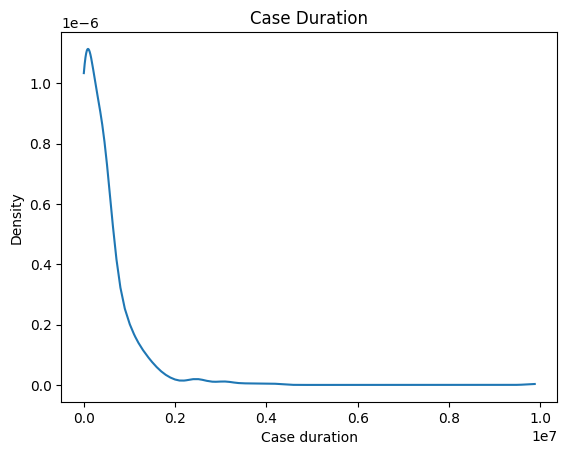

In [55]:
view_case_duration_graph(non_returning_df,kwargs={'pylot_plot_kwargs':{'linestyle':'-'}})

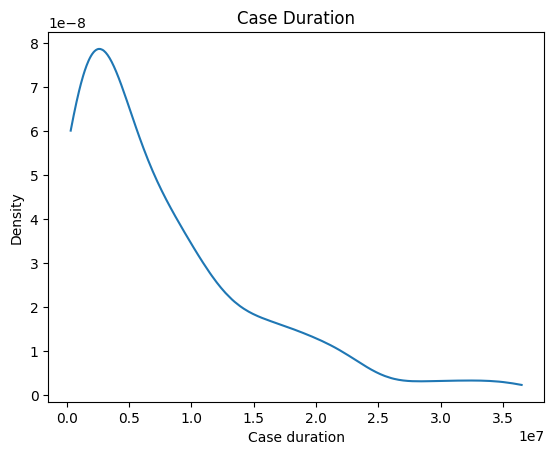

In [56]:
view_case_duration_graph(returning_df,kwargs={'pylot_plot_kwargs':{'linestyle':'-'}})

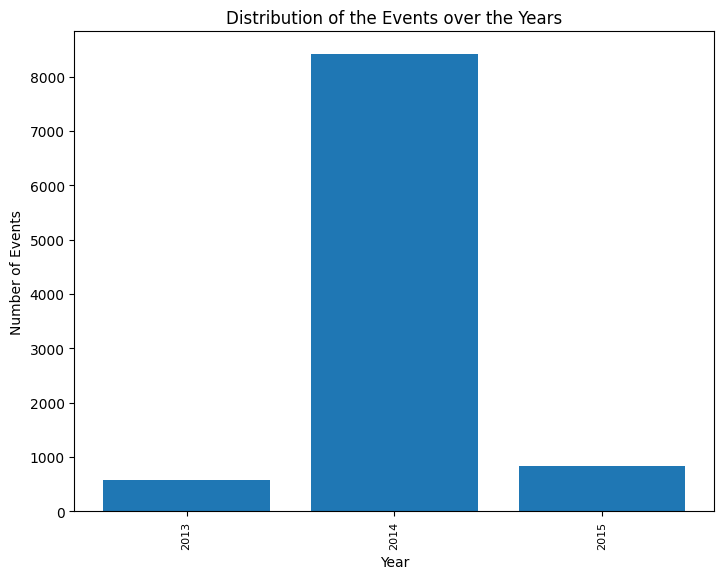

In [57]:
view_events_distribution_graph(non_returning_df,distr_type='years')

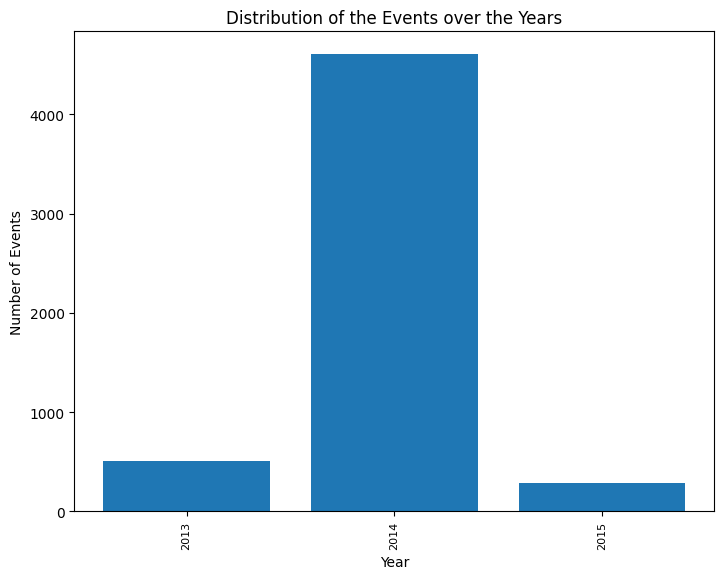

In [58]:
view_events_distribution_graph(returning_df,distr_type='years')

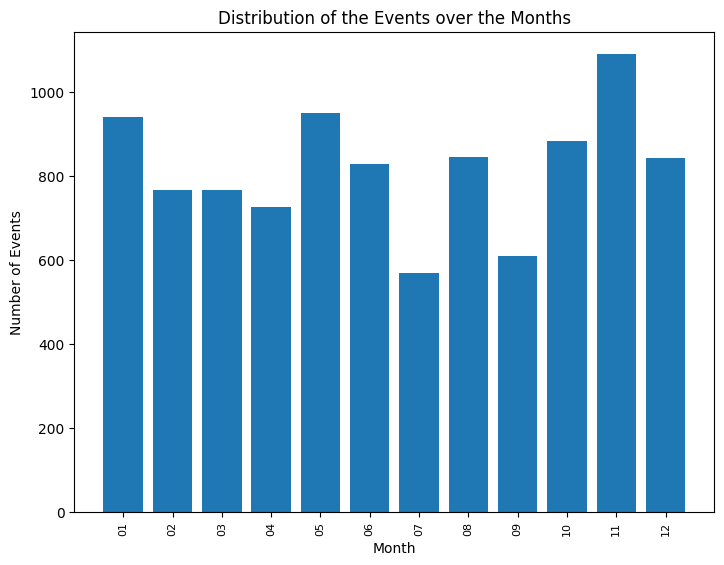

In [59]:
view_events_distribution_graph(non_returning_df,distr_type='months')

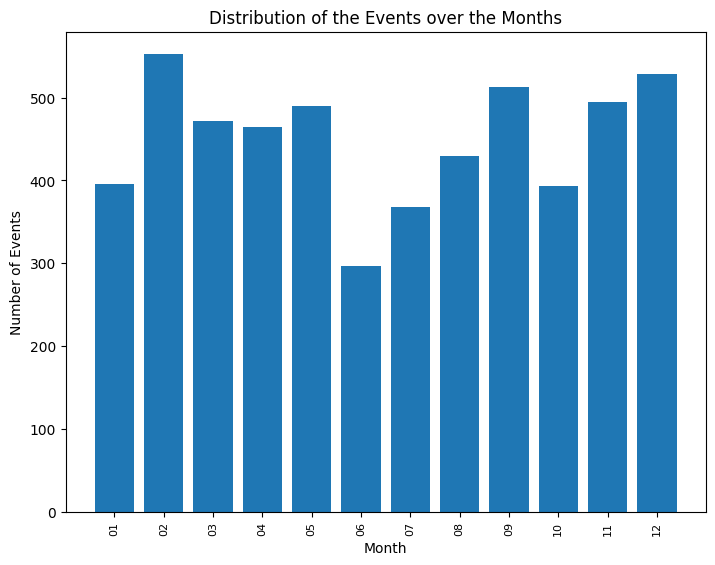

In [60]:
view_events_distribution_graph(returning_df,distr_type='months')

# Part 2.2 Conformance checking
### Rule based conformance checking
Note: Testing for conformance on the same data you used to discover your model will always be a perfect fit

In [61]:
dcr_sepsis, _ = discover_alg.apply(sepsis_df)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(sepsis_df,dcr_sepsis))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]

[Deviation fitness] 1.0


,no_constr_total,deviations,no_dev_total,dev_fitness,is_fit


In [62]:
#TODO 2.2 Load the two models for conformance you created in the portal here
conformance_choice_path = 'models/sepsis_conformance_choice.xml'
conformance_sequence_path = 'models/sepsis_conformance_sequence.xml'

### Choice conformance

In [63]:
conformance_choice = dcr_importer.apply(conformance_choice_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(sepsis_df,conformance_choice))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
print(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts())

[Deviation fitness] 0.9033333333333333
Conforming traces: 685
Non-conforming traces 365
deviations
[(excludeViolation, Admission NC)]                                      323
[(excludeViolation, Admission IC), (excludeViolation, Admission NC)]     26
[(excludeViolation, Admission NC), (excludeViolation, Admission IC)]     15
[(excludeViolation, Admission IC)]                                        1
Name: count, dtype: int64


In [64]:
conformance_choice = dcr_importer.apply(conformance_choice_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(non_returning_df,conformance_choice))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

[Deviation fitness] 0.919973544973545
Conforming traces: 534
Non-conforming traces 222


deviations
[(excludeViolation, Admission NC)]                                      201
[(excludeViolation, Admission IC), (excludeViolation, Admission NC)]     12
[(excludeViolation, Admission NC), (excludeViolation, Admission IC)]      8
[(excludeViolation, Admission IC)]                                        1
Name: count, dtype: int64

In [65]:
conformance_choice = dcr_importer.apply(conformance_choice_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(returning_df,conformance_choice))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

[Deviation fitness] 0.8605442176870748
Conforming traces: 151
Non-conforming traces 143


deviations
[(excludeViolation, Admission NC)]                                      122
[(excludeViolation, Admission IC), (excludeViolation, Admission NC)]     14
[(excludeViolation, Admission NC), (excludeViolation, Admission IC)]      7
Name: count, dtype: int64

### Sequence conformance

In [66]:
conformance_sequence = dcr_importer.apply(conformance_sequence_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(sepsis_df,conformance_sequence))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

[Deviation fitness] 0.986904761904762
Conforming traces: 1024
Non-conforming traces 26


deviations
[(conditionViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Triage, ER Sepsis Triage))]                                                       17
[(conditionViolation, (ER Registration, ER Triage)), (conditionViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Registration, ER Triage))]     5
[(responseViolation, (ER Triage, ER Sepsis Triage))]                                                                                                             3
[(conditionViolation, (ER Registration, ER Triage)), (responseViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Registration, ER Triage))]      1
Name: count, dtype: int64

In [67]:
conformance_sequence = dcr_importer.apply(conformance_sequence_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(non_returning_df,conformance_sequence))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

[Deviation fitness] 0.9900793650793651
Conforming traces: 741
Non-conforming traces 15


deviations
[(conditionViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Triage, ER Sepsis Triage))]                                                       11
[(responseViolation, (ER Triage, ER Sepsis Triage))]                                                                                                             2
[(conditionViolation, (ER Registration, ER Triage)), (conditionViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Registration, ER Triage))]     2
Name: count, dtype: int64

In [68]:
conformance_sequence = dcr_importer.apply(conformance_sequence_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(returning_df,conformance_sequence))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

[Deviation fitness] 0.9787414965986394
Conforming traces: 283
Non-conforming traces 11


deviations
[(conditionViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Triage, ER Sepsis Triage))]                                                       6
[(conditionViolation, (ER Registration, ER Triage)), (conditionViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Registration, ER Triage))]    3
[(conditionViolation, (ER Registration, ER Triage)), (responseViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Registration, ER Triage))]     1
[(responseViolation, (ER Triage, ER Sepsis Triage))]                                                                                                            1
Name: count, dtype: int64

# Other Discovery algorithms for imperative notations
### BPMN (observe the differences between the discovered model and the idealized one from the assignment 2.2 exercise)

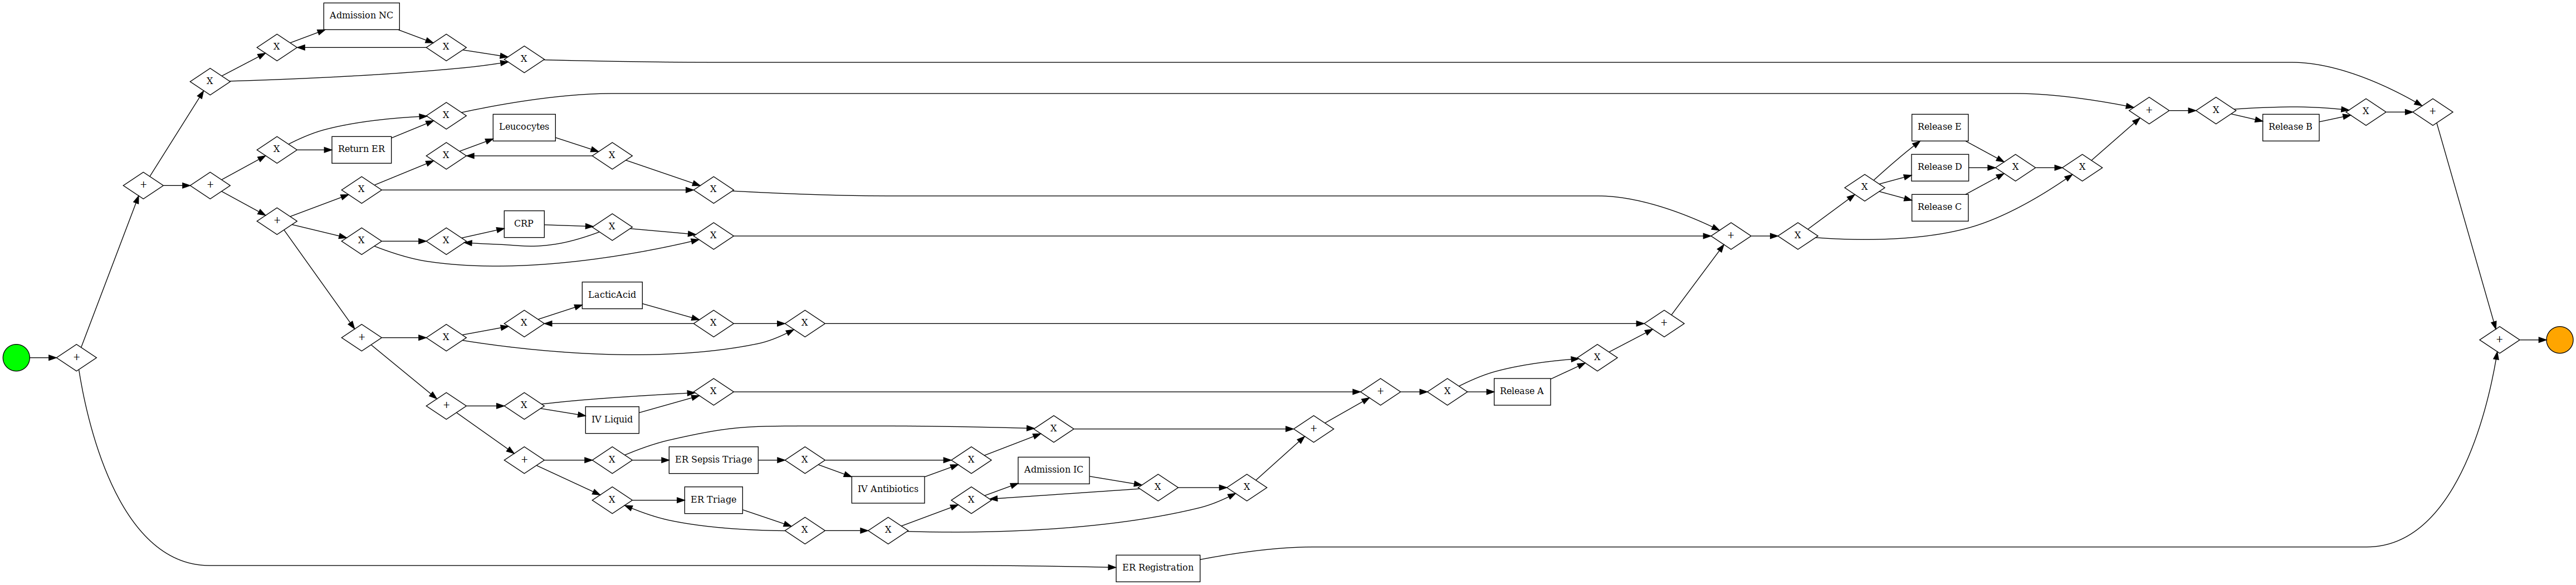

In [69]:
bpmn_sepsis = pm4py.discovery.discover_bpmn_inductive(sepsis_df)
pm4py.view_bpmn(bpmn_sepsis)

## BPMN filtering to discover only from 0.8 (80%) most common traces.

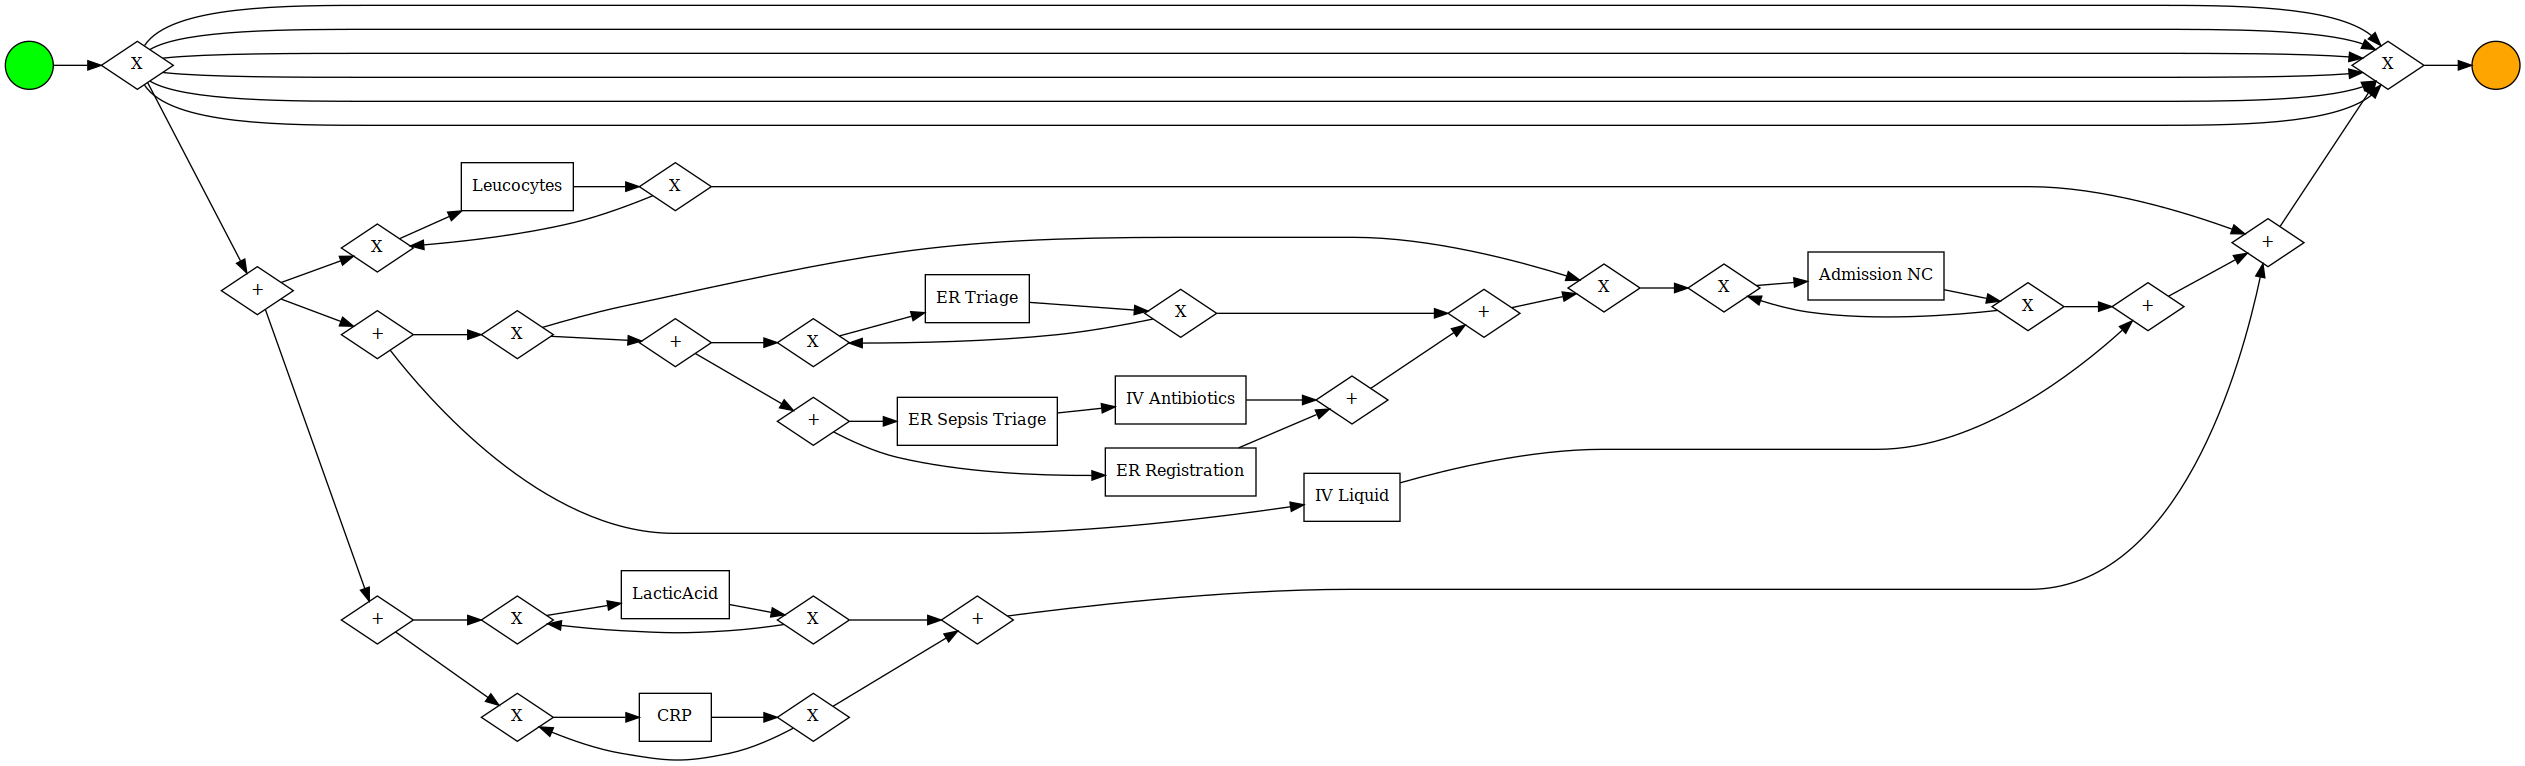

In [70]:
bpmn_filtered = pm4py.discover_bpmn_inductive(sepsis_df, 0.8)
pm4py.view_bpmn(bpmn_filtered)

## Directly follows graph

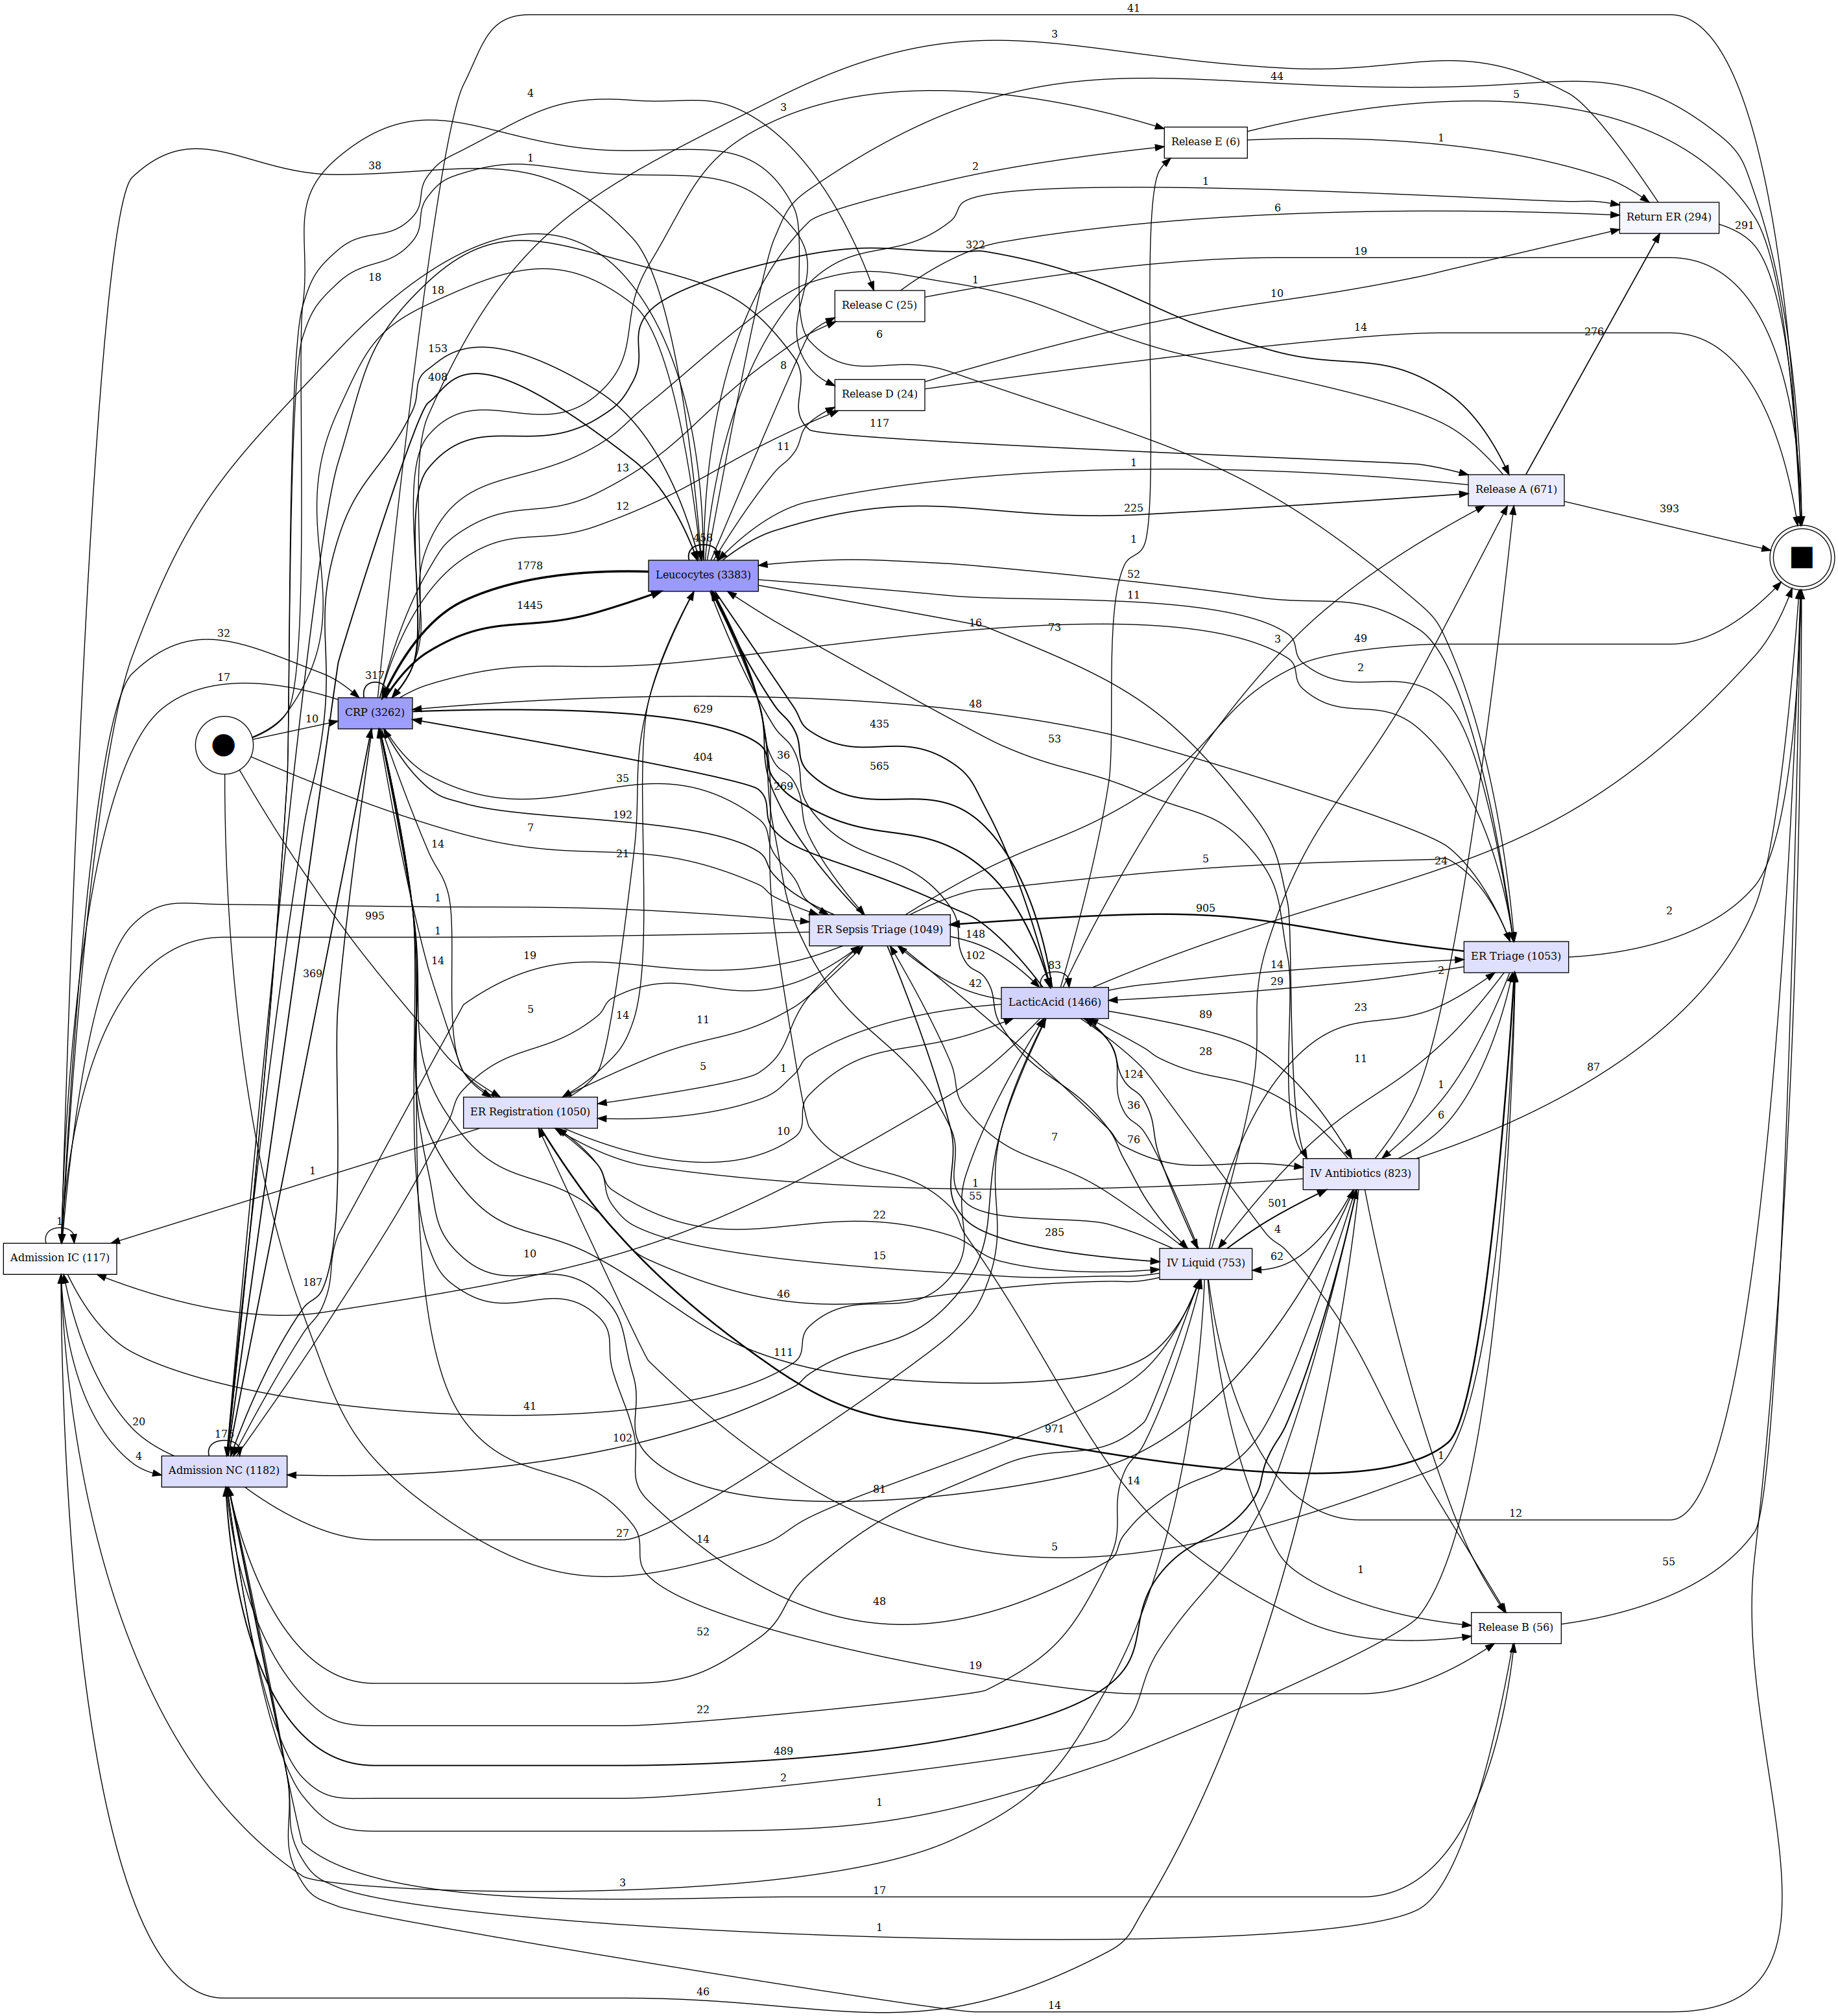

In [71]:
dfg, start_activities, end_activities = pm4py.discover_dfg(sepsis_df)
pm4py.view_dfg(dfg, start_activities, end_activities)

## A view of the Directly Follows Graph that shows only the top 20 most frequent edges

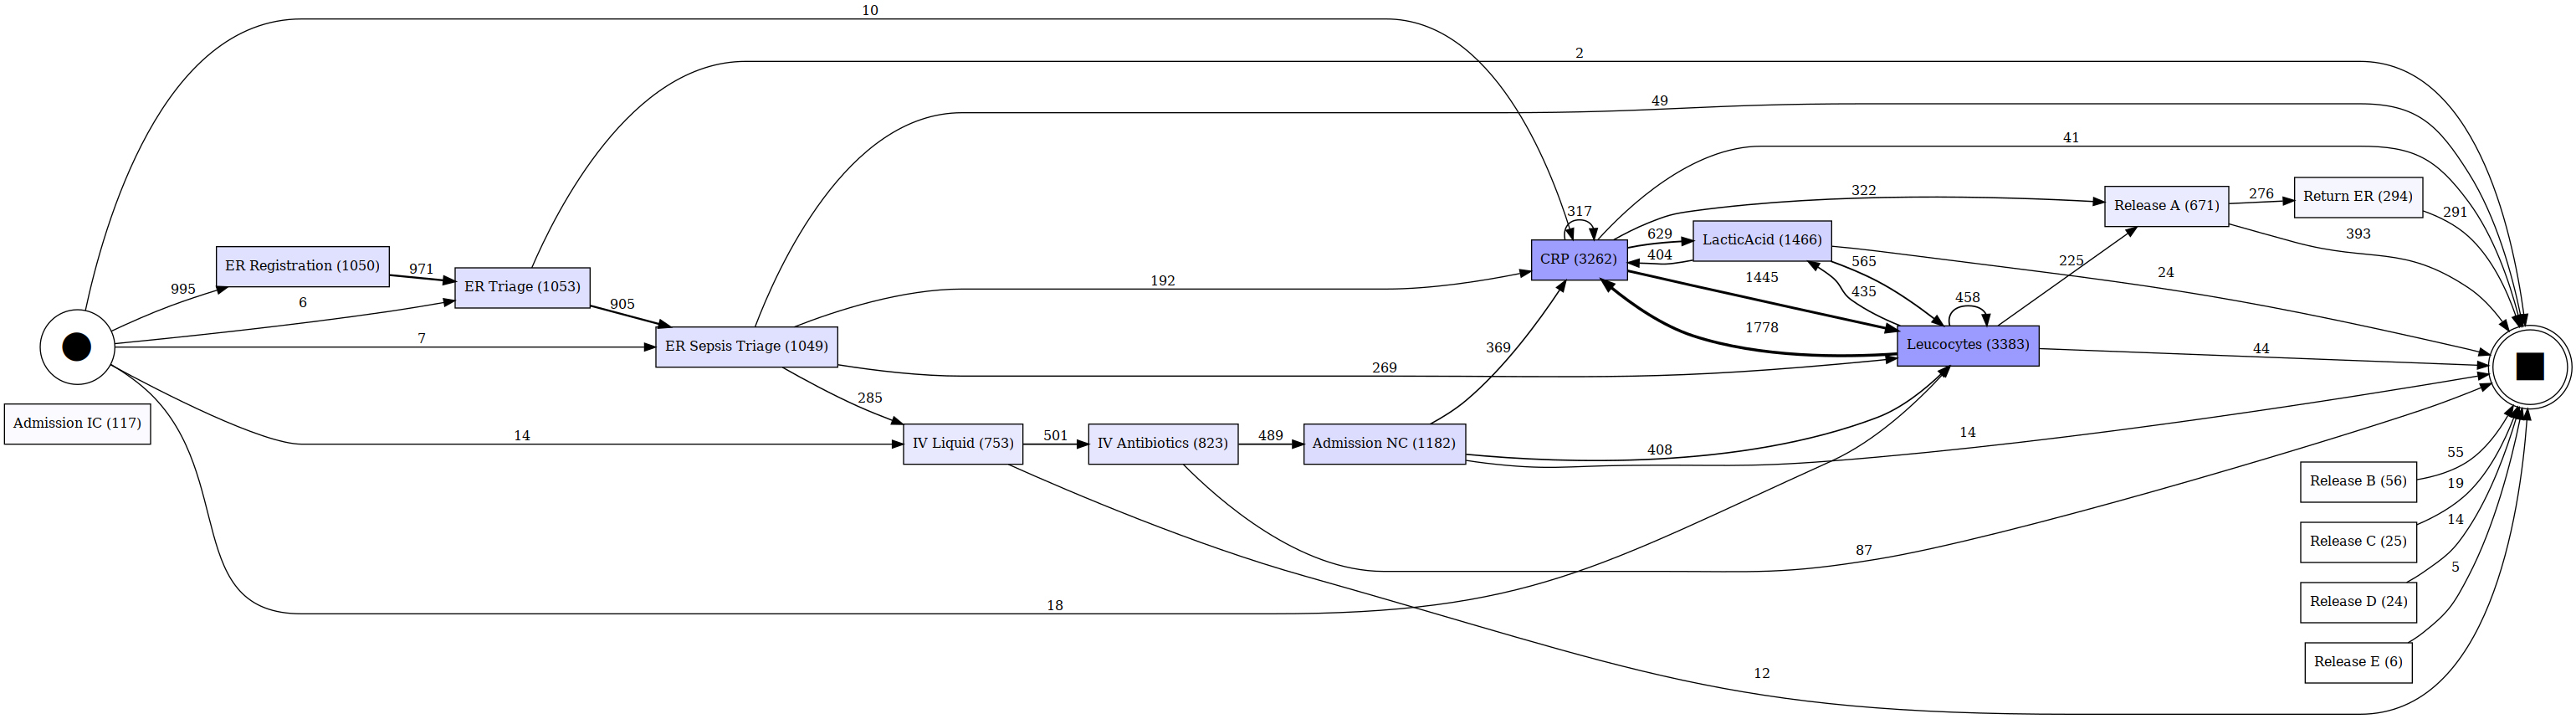

In [72]:
pm4py.view_dfg(dfg, start_activities, end_activities, max_num_edges=20)

## Alignment based conformance
Note: Testing for conformance on the same data you used to discover your model will always be a perfect fit

In [73]:
dcr_sepsis, _ = discover_alg.apply(sepsis_df)
alignment_sepsis_df = pd.DataFrame(alignments_dcr.apply(sepsis_df,DcrGraph(template=dcr_sepsis.obj_to_template())))
print(f'[Alignment fitness] {alignment_sepsis_df["fitness"].mean()}')
alignment_sepsis_df[alignment_sepsis_df['fitness']<1]

[Alignment fitness] 1.0


,alignment,cost,visited_states,closed,global_min,fitness,bwc


In [76]:
# conformance_choice = dcr_importer.apply('models/sepsis_conformance_admission_mutual_exclusion.xml')
alignment_sepsis_df = pd.DataFrame(alignments_dcr.apply(sepsis_df,DcrGraph(template=conformance_choice.obj_to_template())))
print(f'[Deviation fitness] {alignment_sepsis_df["fitness"].mean()}')
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']==1]))
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]))
alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]['alignment'].value_counts()

[Deviation fitness] 0.9604529815268884
240
810


alignment
[(ER Registration, ER Registration), (ER Triage, ER Triage), (ER Sepsis Triage, ER Sepsis Triage), (Leucocytes, Leucocytes), (CRP, CRP), (>>, Admission NC), (Release A, Release A)]                                                                                                                                                                                                            5
[(ER Registration, ER Registration), (ER Triage, ER Triage), (ER Sepsis Triage, ER Sepsis Triage), (CRP, CRP), (Leucocytes, Leucocytes), (>>, Admission NC), (Release A, Release A)]                                                                                                                                                                                                            4
[(ER Registration, ER Registration), (ER Triage, ER Triage), (ER Sepsis Triage, ER Sepsis Triage), (Leucocytes, Leucocytes), (LacticAcid, LacticAcid), (CRP, CRP), (IV Liquid, IV Liquid), (IV Antibiotics, IV Antibiotics

In [77]:
# conformance_sequence = dcr_importer.apply('models/sepsis_conformance_registration_triage_chain.xml')
alignment_sepsis_df = pd.DataFrame(alignments_dcr.apply(sepsis_df,DcrGraph(template=conformance_sequence.obj_to_template())))
print(f'[Deviation fitness] {alignment_sepsis_df["fitness"].mean()}')
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']==1]))
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]))
alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]['alignment'].value_counts()

[Deviation fitness] 0.9987711643958879
1024
26


alignment
[(ER Sepsis Triage, ER Sepsis Triage), (ER Registration, ER Registration), (ER Triage, ER Triage), (Leucocytes, Leucocytes), (CRP, CRP), (ER Sepsis Triage, >>)]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1
[(ER Registration, ER Registration), (ER Sepsis Triage, ER Sepsis Triage), (IV Antibiotics, IV Antibiotics), (ER Triage,